In [1]:
import os  # Модуль для взаємодії з операційною системою
import numpy as np  # Бібліотека для роботи з масивами даних
import pandas as pd  # Бібліотека для аналізу та обробки даних у форматі таблиць
import matplotlib.pyplot as plt  # Бібліотека для візуалізації даних

from sklearn.model_selection import KFold, StratifiedKFold  # Модулі для реалізації різних стратегій крос-валідації
from sklearn.linear_model import LogisticRegression  # Логістична регресія - модель класифікації
from sklearn.metrics import classification_report  # Метрики для оцінки якості класифікації
import seaborn as sns

import warnings
warnings.filterwarnings(action="ignore")

## Data Load and Visualizations

In [2]:
df = pd.read_csv(os.path.join("data", "mnist_train.csv"))  # Зчитуємо навчальні дані з CSV файлу
print(df.shape)  # Виводимо розмір таблиці
df.head()  # Виводимо перші декілька записів

(60000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_test = pd.read_csv(os.path.join("data", "mnist_test.csv"))  # Зчитуємо тестові дані з CSV файлу
print(df_test.shape)  # Виводимо розмір таблиці тестових даних
df_test.head()  # Виводимо перші декілька записів тестових даних

(10000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


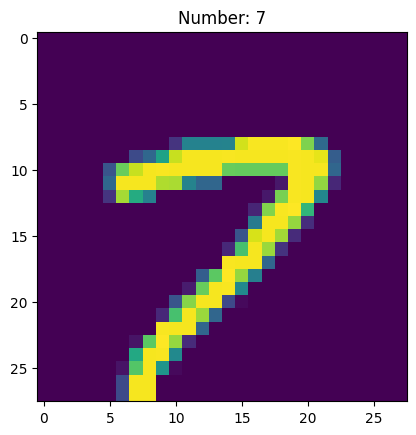

In [4]:
idx = 123  # Індекс зразка, який хочемо візуалізувати
label = df.iloc[idx, 0]  # Отримуємо мітку (цифру) для вибраного зразка
sample = df.iloc[idx, 1:]  # Отримуємо піксельні дані для вибраного зразка
sample = np.reshape(sample, (28, 28))  # Перетворюємо плоский масив у двовимірний зображення розміром 28x28

plt.title(f"Number: {label}")  # Встановлюємо заголовок з міткою (цифрою) зразка
plt.imshow(sample);  # Візуалізуємо зразок

In [5]:
def sample_as_img(sample):
    label = sample[0]  # Отримуємо мітку (цифру)
    img = np.reshape(sample[1:], (28, 28))  # Перетворюємо плоский масив у двовимірний зображення розміром 28x28
    return img, label

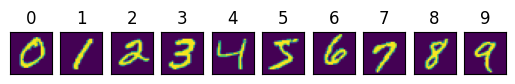

In [6]:
fix, axes = plt.subplots(ncols=10)  # Створюємо сітку з 10 графіками в одному рядку
for i in range(10):
    sample = df[df["label"] == i].iloc[0]  # Вибираємо перший зразок для кожної цифри
    img, label = sample_as_img(sample)  # Отримуємо зображення та мітку для поточного зразка
    ax = axes[i]  # Вибираємо поточний графік з сітки
    ax.imshow(img)  # Візуалізуємо зображення
    ax.set_title(label)  # Встановлюємо заголовок графіку з міткою (цифрою)
    # Приховуємо мітки маркерів X та Y
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    # Приховуємо позначки маркерів X та Y
    ax.set_xticks([])
    ax.set_yticks([])

#### TODO: Data Check

Проаналізуйте дані - візуалізуйте розподіл класів (таргета), візуалізуйте приклади класів.

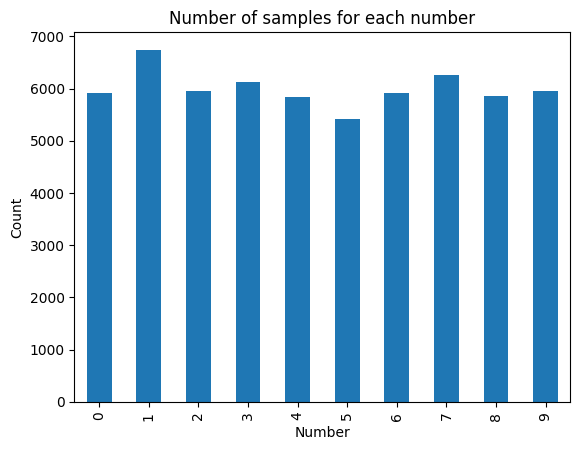

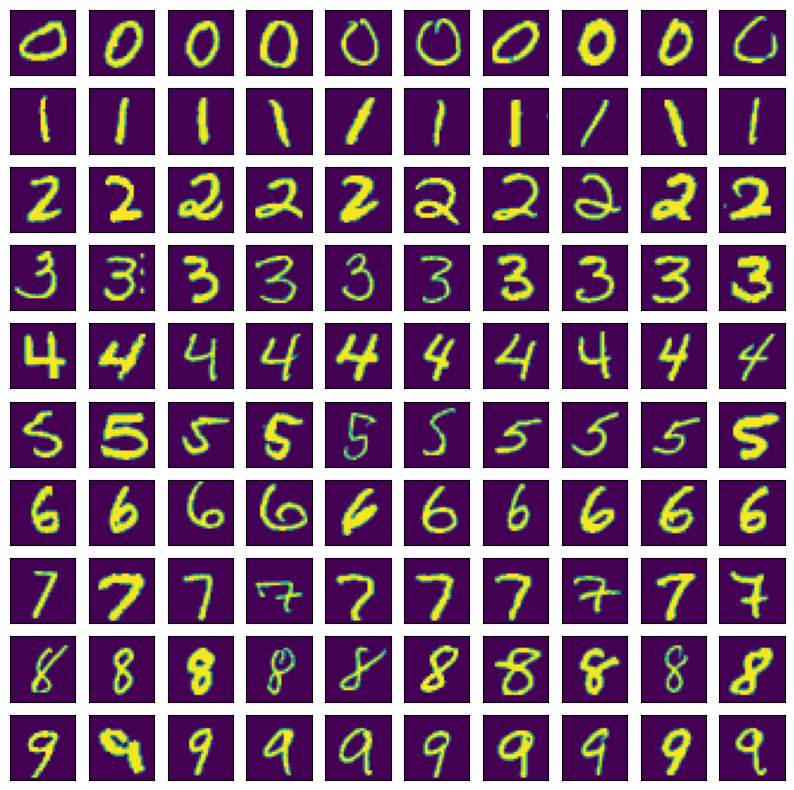

In [7]:
df["label"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Number")
plt.ylabel("Count")
plt.title("Number of samples for each number")

fix, axes = plt.subplots(ncols=10, nrows=10, figsize=(10, 10))
rng = np.random.default_rng()
for i in range(10):
    samples = df[df["label"] == i]
    for j, sample in samples.sample(10, random_state=rng.integers(0, len(samples)), ignore_index=True).iterrows():
        img, label = sample_as_img(sample)
        ax = axes[i, j]
        ax.imshow(img)
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])

## Modeling & Evaluation

#### TODO

На основі розподілу даних оберіть метрику яку оптимізуватимете (accuracy, precision, recall, $F_1$) і напишіть чому саме такий вибір.

- Дивлячись на розподіл класів можна сказати що вони сбалансовані, тому accuracy має достатньо добре вимірювати точність моделі.

Знайдіть модель яка найкраще б працювала на тестових даних (спробуйте різні значення для параметру `penalty : {‘l1’, ‘l2’, ‘elasticnet’, None}`). Напишіть метрики моделей на тестових даних які перевіряли.

In [8]:
# Побудова наборів даних
X = df.iloc[:, 1:].values / 255.0  # Конвертація значень пікселів з діапазону [0..255] до [0,1]
y = df.iloc[:, 0].values  # Вибір міток класів (цифр)

X_test = df_test.iloc[:, 1:].values / 255.0  # Конвертація значень пікселів тестового набору даних з [0..255] до [0,1]
y_test = df_test.iloc[:, 0].values  # Вибір міток класів для тестового набору даних

In [9]:
n_folds = 5  # Кількість фолдів для крос-валідації

for fold_idx, (train_idxs, valid_idxs) in enumerate(KFold(n_splits=n_folds).split(X)):
    x_train, y_train = X[train_idxs], y[train_idxs]  # Отримання тренувального набору
    x_valid, y_valid = X[valid_idxs], y[valid_idxs]  # Отримання валідаційного набору
    model = LogisticRegression(penalty=None)  # Створення моделі логістичної регресії
    model.fit(x_train, y_train)  # Навчання моделі на тренувальних даних
    y_pred = model.predict(x_valid)  # Прогнозування на валідаційних даних
    report = classification_report(y_valid, y_pred)  # Оцінка якості класифікації на валідаційних даних
    print(f"\n[Fold {fold_idx+1}/{n_folds}]")  # Вивід номера фолду
    print(report)  # Вивід звіту про класифікацію для поточного фолду


[Fold 1/5]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1206
           1       0.95      0.97      0.96      1351
           2       0.91      0.90      0.91      1176
           3       0.89      0.89      0.89      1228
           4       0.92      0.94      0.93      1184
           5       0.91      0.88      0.89      1048
           6       0.94      0.96      0.95      1208
           7       0.95      0.92      0.94      1279
           8       0.89      0.85      0.87      1127
           9       0.90      0.92      0.91      1193

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000


[Fold 2/5]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1175
           1       0.96      0.97      0.96      1381
           2       0.90      0.88      0.89      1171


In [11]:
for penalty in ["l1", "l2", "elasticnet", None]:
    print(f"\nPenalty: {penalty}")
    model = LogisticRegression(penalty=penalty, l1_ratio=0.5, solver="saga", max_iter=50)  # Створення моделі логістичної регресії для тестування
    model.fit(X, y)  # Навчання моделі на всіх навчальних даних

    print(f"\tTrain accuracy: {model.score(X, y):.4f}")  # Оцінка якості класифікації на навчальних даних
    print(f"\tTest accuracy: {model.score(X_test, y_test):.4f}", )  # Оцінка якості класифікації на тестових даних

    print("\t", classification_report(y_test, model.predict(X_test)))  # Оцінка якості класифікації на тестових даних та виведення звіту


Penalty: l1
	Train accuracy: 0.9358
	Test accuracy: 0.9267
	               precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.92      1032
           3       0.91      0.91      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.90      0.87      0.89       892
           6       0.94      0.95      0.95       958
           7       0.93      0.93      0.93      1028
           8       0.88      0.89      0.88       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000


Penalty: l2
	Train accuracy: 0.9373
	Test accuracy: 0.9265
	               precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
        